# IMDb Sentiment Analysis with Bidirectional LSTM

This notebook builds a sentiment classifier for IMDb movie reviews using TensorFlow/Keras. We walk through loading the dataset, preparing padded sequences, training a bidirectional LSTM, and evaluating performance.

**Pipeline overview**

1. Setup and imports  
2. Load and inspect the IMDb dataset  
3. Preprocess sequences with padding and exploratory checks  
4. Train a bidirectional LSTM baseline  
5. Evaluate accuracy and error patterns, then outline next steps

Dataset: TensorFlow/Keras IMDb reviews (25k train / 25k test) with integer-encoded tokens sorted by frequency.


## 1. Setup and Imports

Configure core libraries, reproducibility seeds, and training hyperparameters used throughout the workflow.


In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)



print(f"Working directory: {os.getcwd()}")


Working directory: c:\Users\asus\OneDrive - Universidade de Aveiro\Documents\GitHub\RNN_Practicise_exercises-solution


## 2. Load

Download the IMDb movie-review dataset limited to the `NUM_WORDS=10000` most frequent tokens.

In [31]:
# Hyperparameter
NUM_WORDS = 10000        # keep the top-N most frequent tokens

#Load the IMDb dataset
(x_train_raw, y_train), (x_test_raw, y_test) = imdb.load_data(num_words=NUM_WORDS, index_from=3)

### 2.1 Inspect the data

This section helps understanding and verifying the data before feeding it into the neural network.
* Confirms dataset size;

* Reconstructs the word dictionary;

* Makes numeric reviews human-readable;

* Displays example reviews and labels;

* Checks that classes are balanced.



In [26]:
# Print the number of training and test samples (with thousands separator)
print(f"Training samples: {len(x_train_raw):,}")
print(f"Test samples: {len(x_test_raw):,}")

# -------------------------------------------------------------
# Build a reverse dictionary for the IMDb dataset (word <-> index)
# -------------------------------------------------------------

# Load the original word-index mapping (word → integer)
word_index = imdb.get_word_index()

# Shift all indices by +3 to leave space for special tokens
word_index = {k: (v + 3) for k, v in word_index.items()}

# Add reserved tokens used in the dataset
word_index['<PAD>'] = 0      # Padding token (used to fill shorter sequences)
word_index['<START>'] = 1    # Marks the beginning of a review
word_index['<UNK>'] = 2      # Unknown word (not in vocabulary)
word_index['<UNUSED>'] = 3   # Reserved for potential future use

# Create a reversed dictionary (index → word) for decoding reviews
reverse_word_index = {value: key for key, value in word_index.items()}

# -------------------------------------------------------------
# Function to convert a sequence of integers back into words
# -------------------------------------------------------------
def decode_review(sequence):
    # Replace each integer with its corresponding word, or '?' if not found
    return ' '.join(reverse_word_index.get(i, '?') for i in sequence)

# -------------------------------------------------------------
# Create a label map for sentiment categories
# -------------------------------------------------------------
label_map = {0: 'negative', 1: 'positive'}

# -------------------------------------------------------------
# Print an example decoded review and its sentiment label
# -------------------------------------------------------------
print("Example decoded review:")
print(decode_review(x_train_raw[0])[:500], "...")   # Show first 500 characters
print(f"Label: {label_map[y_train[0]]}")

# -------------------------------------------------------------
# Display the class distribution in the training data
# -------------------------------------------------------------
class_distribution = pd.Series(y_train).value_counts().sort_index()
print("Class distribution (train):")
print(class_distribution.rename(index=label_map))



Training samples: 25,000
Test samples: 25,000
Example decoded review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would re ...
Label: positive
Class distribution (train):
negative    12500
positive    12500
Name: count, dtype: int64


## 3. Preprocess: Padding

Pad each review to `MAX_LEN=200` tokens to obtain fixed-length tensors and inspect raw-length statistics to justify the padding choice.


In [35]:
MAX_LEN = 100            # pad / truncate each review to this length

train_lengths = [len(seq) for seq in x_train_raw]
test_lengths = [len(seq) for seq in x_test_raw]

x_train = pad_sequences(
    x_train_raw,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)
x_test = pad_sequences(
    x_test_raw,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")


x_train shape: (25000, 100)
x_test shape: (25000, 100)


## 4. Build the Bidirectional LSTM Model

Stack an embedding layer with a bidirectional LSTM to capture contextual information from both directions, then pool and classify with dense layers.


In [ ]:
#hyperparameters
EMBEDDING_DIM = 32
LSTM_UNITS = 64


# ===============================================================
# 🧩 IMPORTS
# ===============================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

# HYPERPARAMETERS 
top_words = 10000          # number of most frequent words to keep
max_review_length = 500    # maximum number of words per review

# ===============================================================
# 🧠 MODEL DEFINITION
# ===============================================================
from tensorflow.keras import Input

model = Sequential([
    tf.keras.layers.Input(shape=(max_review_length,)),  # 👈 Define the input shape explicitly
    tf.keras.layers.Embedding(input_dim=top_words, output_dim=EMBEDDING_DIM, input_length=max_review_length),
    tf.keras.layers.Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# ===============================================================
# ⚙️ MODEL COMPILATION
# ===============================================================
# Adam optimizer adjusts learning rate automatically
# Binary crossentropy is used for binary sentiment classification (positive/negative)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ===============================================================
# 📋 MODEL SUMMARY
# ===============================================================
model.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 500, 128)       │        49,664 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,745 (1.42 MB)

 Trainable params: 371,745 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model

Fit the network with early stopping on validation accuracy to reduce overfitting.


In [53]:
#Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
VALIDATION_SPLIT = 0.2


history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1 # Show information in epochs
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8555 - loss: 0.3468 - val_accuracy: 0.8192 - val_loss: 0.4160
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8913 - loss: 0.2762 - val_accuracy: 0.8226 - val_loss: 0.4423
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9155 - loss: 0.2216 - val_accuracy: 0.8134 - val_loss: 0.5469
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9348 - loss: 0.1787 - val_accuracy: 0.8132 - val_loss: 0.5390
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9447 - loss: 0.1516 - val_accuracy: 0.8106 - val_loss: 0.6089
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9550 - loss: 0.1249 - val_accuracy: 0.8074 - val_loss: 0.7274
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9622 - loss: 0.1044 - val_accuracy: 0.7992 - val_loss: 0.7934
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9669 - loss: 0.0922 - 

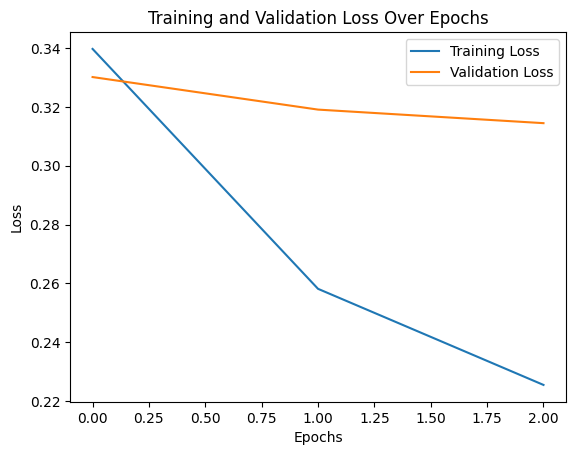

In [33]:
# Training diagnostics loss curve
plt.plot(history.history['loss']) # Plotting training loss
plt.plot(history.history['val_loss']) # Plotting validation loss
plt.title("Training and Validation Loss Over Epochs") # Adding title
plt.xlabel("Epochs") # Adding x-axis label
plt.ylabel("Loss") # Adding y-axis label
plt.legend(["Training Loss", "Validation Loss"])
plt.show() # Displaying the plot

## 6. Evaluate and Interpret Results

Assess generalisation on the test set, inspect detailed classification metrics, and visualise the confusion matrix. Plot learning curves to understand optimisation behaviour.


Test loss: 0.3372
Test accuracy: 0.8522
Classification report:
              precision    recall  f1-score   support

    negative       0.89      0.80      0.84     12500
    positive       0.82      0.90      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



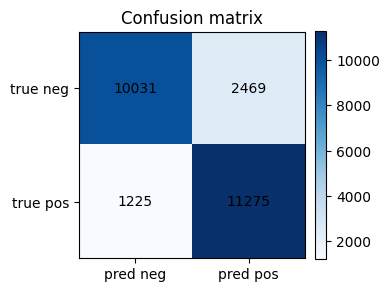

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict
y_pred = model.predict(x_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


## Next Steps

- Explore alternative model architectures (stacked LSTMs, GRUs, or convolutional front-ends) 
- Increase `NUM_WORDS` or `MAX_LEN` and observe the trade-off between vocabulary coverage and training cost.
- Add regularisation such as dropout, or incorporate pre-trained word embeddings (e.g., GloVe) for richer representations.
